In [1]:
from mpc import *

In [2]:
# Total simulation time 24h (1440m)
total_time = 1440  

# Sample time 1m
t_step = 1

# Number of control step total_time/t_step: 1440
steps = int(total_time/t_step) 

# Get average trajectory every 240 m
avg_period = 240  

# Initial conditions
x_0 = np.array([30, 50, 400, 125, 0, 0])

# References
LacI_ref = 750
TetR_ref = 300


# Dynamic Model

This function defines the mathematical model for the toggle switch in the form of differential equations with random parameters.

In [3]:
def template_model(LacI_ref = 750, TetR_ref = 300):

    model = do_mpc.model.Model(model_type='continuous')

    # Model states
    mRNA_LacI = model.set_variable(var_type='states', var_name='mRNA_LacI')
    mRNA_TetR = model.set_variable(var_type='states', var_name='mRNA_TetR')
    lacI = model.set_variable(var_type='states', var_name='LacI')
    tetR = model.set_variable(var_type='states', var_name='TetR')
    v1 = model.set_variable(var_type='states', var_name='v1')
    v2 = model.set_variable(var_type='states', var_name='v2')

    # Model inputs
    aTc = model.set_variable(var_type='inputs', var_name='aTc')
    iptg = model.set_variable(var_type='inputs', var_name='IPTG')

    # Model parameters
    k_m0_L = np.random.uniform(low=3.00e-2, high=4.00e-2)
    k_m0_T = np.random.uniform(low=1.00e-1, high=2.00e-1)
    k_m_L = np.random.uniform(low=7, high=10)
    k_m_T = np.random.uniform(low=1, high=4)
    k_p_L = np.random.uniform(low=9.00e-1, high=10.00e-1)
    k_p_T = np.random.uniform(low=9.00e-1, high=10.00e-1)
    g_m_L = np.random.uniform(low=1.00e-1, high=1.50e-1)
    g_m_T = np.random.uniform(low=1.00e-1, high=1.50e-1)
    g_p_L = np.random.uniform(low=1.50e-2, high=1.70e-2)
    g_p_T = np.random.uniform(low=1.50e-2, high=1.70e-2)
    theta_IPTG = np.random.uniform(low=9.00e-2, high=9.10e-2)
    theta_aTc = np.random.uniform(low=5, high=2)
    eta_LacI = 2.00
    eta_TetR = 2.00
    eta_IPTG = 2.00
    eta_aTc = 2.00
    k_in_aTc = np.random.uniform(low=2.50e-2, high=3.00e-2)
    k_out_aTc = np.random.uniform(low=2.00e-2, high=2.30e-2)
    k_in_IPTG = np.random.uniform(low=1.00e-1, high=2.00e-1)
    k_out_IPTG = np.random.uniform(low=1.00e-1, high=2.00e-1)
    theta_LacI = np.random.uniform(low=20, high=40)
    theta_TetR = np.random.uniform(low=20, high=40)
    

    # Defining model's equations
    model.set_rhs('mRNA_LacI', k_m0_L + k_m_L*(1 / (1 + ((tetR/theta_TetR) * (1 / (1 + (v1/theta_aTc)**eta_aTc)))**eta_TetR)) - g_m_L * mRNA_LacI)
    model.set_rhs('mRNA_TetR', k_m0_T + k_m_T*(1 / (1 + ((lacI/theta_LacI) * (1 / (1 + (v2/theta_IPTG)**eta_IPTG)))**eta_LacI)) - g_m_T * mRNA_TetR)
    model.set_rhs('LacI', k_p_L * mRNA_LacI - g_p_L * lacI)
    model.set_rhs('TetR', k_p_T * mRNA_TetR - g_p_T * tetR)
    model.set_rhs('v1', (k_in_aTc * (aTc - v1)) * (aTc > v1) + (k_out_aTc * (aTc - v1)) * (aTc <= v1))
    model.set_rhs('v2', (k_in_IPTG * (iptg - v2)) * (iptg > v2) + (k_out_IPTG * (iptg - v2)) * (iptg <= v2))

    # Cost function
    model.set_expression(expr_name='cost', expr=((lacI - LacI_ref)**2 + (tetR - TetR_ref)**2))

    model.setup()

    return model


## Control loop
Control loop for the randomic model.

In [4]:
%%capture

setup_mpc = {
    'n_robust': 1,
    'n_horizon': 10,
    't_step': t_step,
    'store_full_solution': True,
}

model = template_model()
mpc = template_mpc(model, setup_mpc=setup_mpc)
simulator = template_simulator(model, t_step)
estimator = do_mpc.estimator.StateFeedback(model)

simulator.reset_history()

mpc.x0 = x_0
simulator.x0 = x_0
estimator.x0 = x_0

mpc.set_initial_guess()

for k in range(steps):

    u = mpc.make_step(x_0)

    if (mpc.t0 - t_step) % 15 == 0:
        ukm1 = u
    else:
        u = ukm1

    y_next = simulator.make_step(u)
    x_0 = estimator.make_step(y_next)
        
data = save_results(mpc, avg_period, t_step)


## Compute performance metrics and plot results

------------------------------ PERFORMANCES METRICS ------------------------------
ISE: 1.90e+02
ITAE: 3.98e+05
------------------------------ PLOT RESULTS ------------------------------


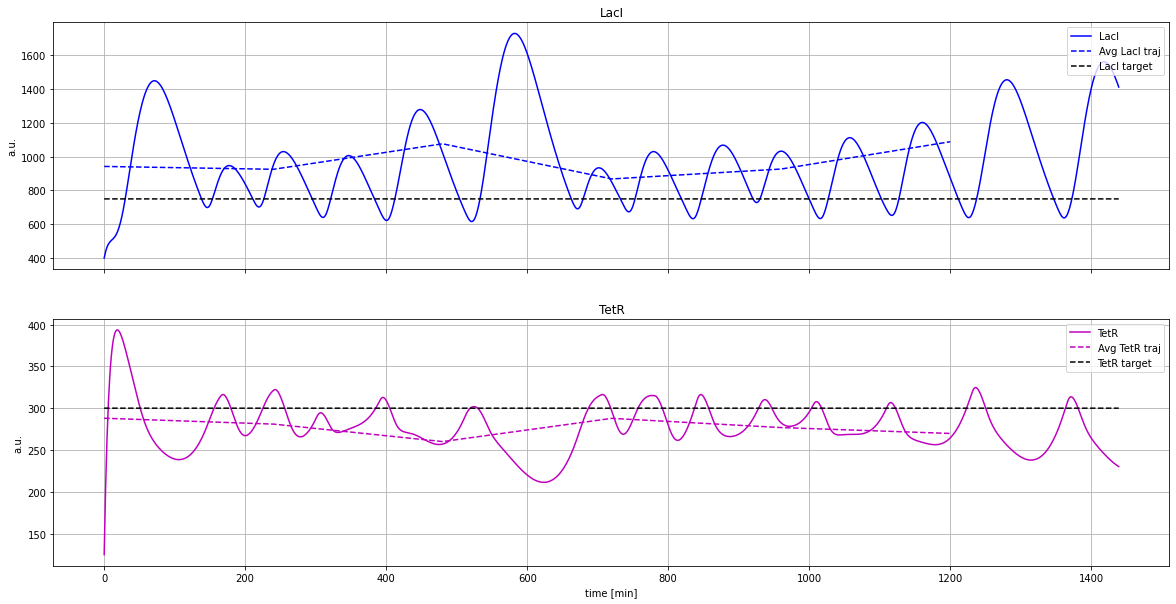

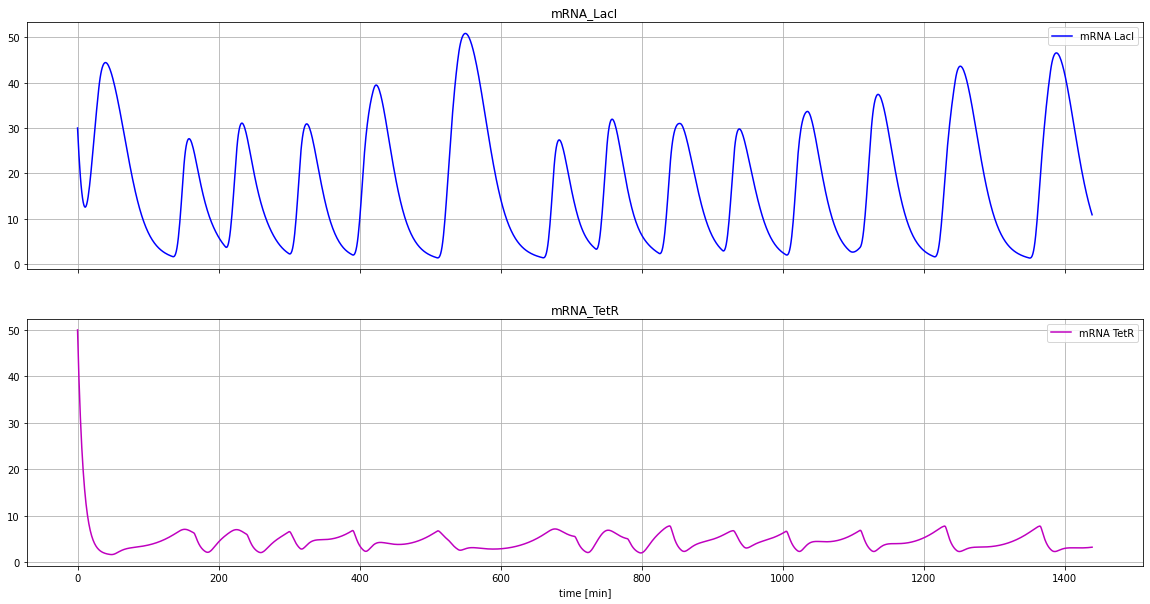

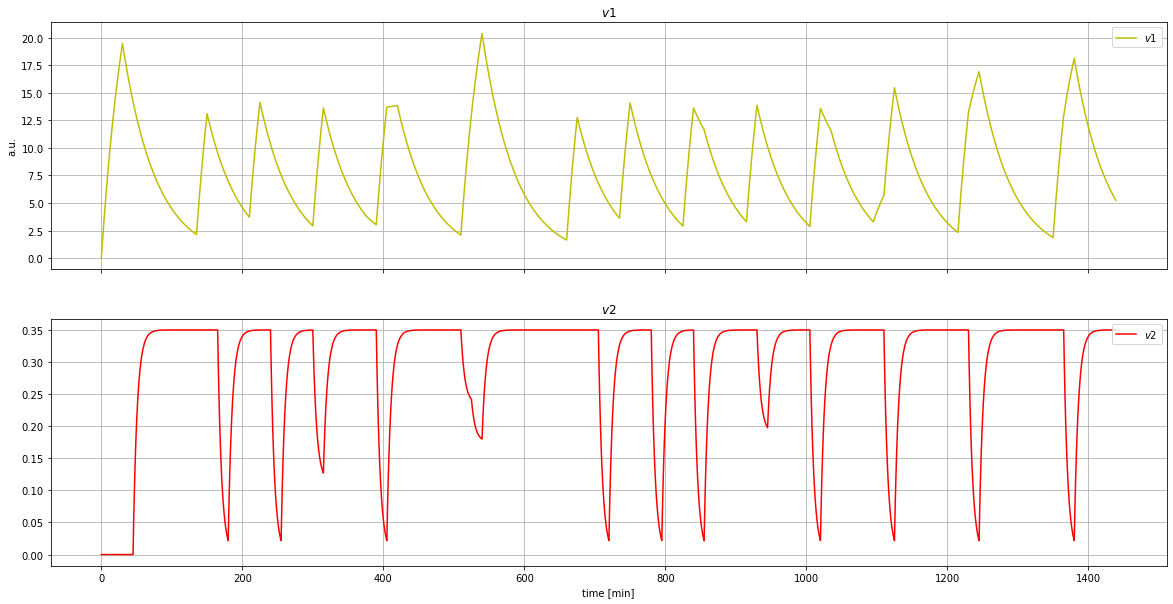

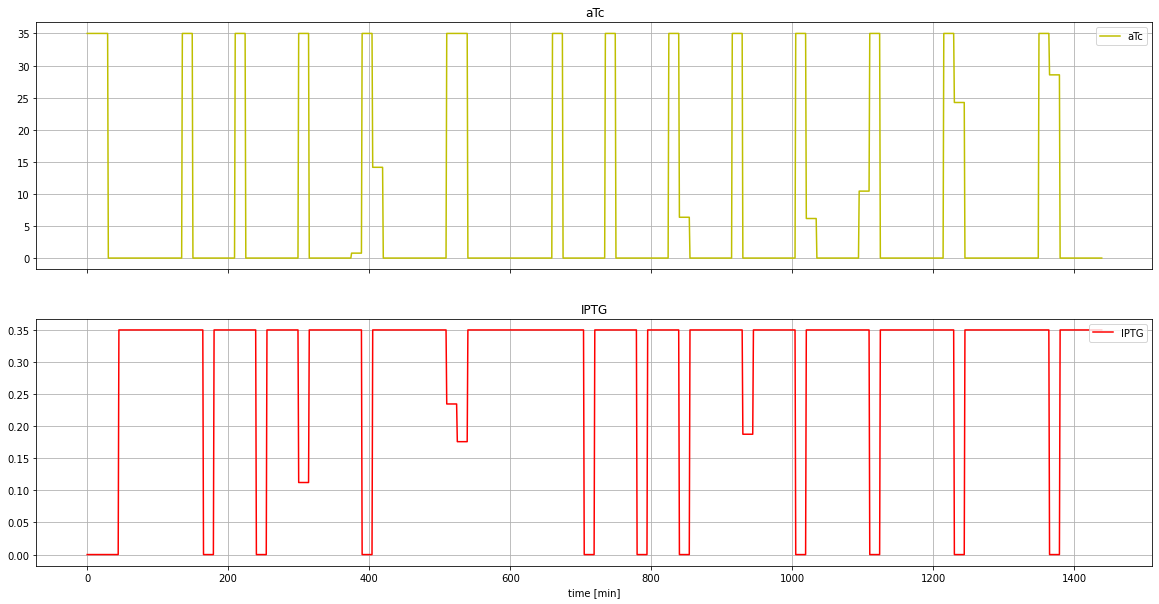

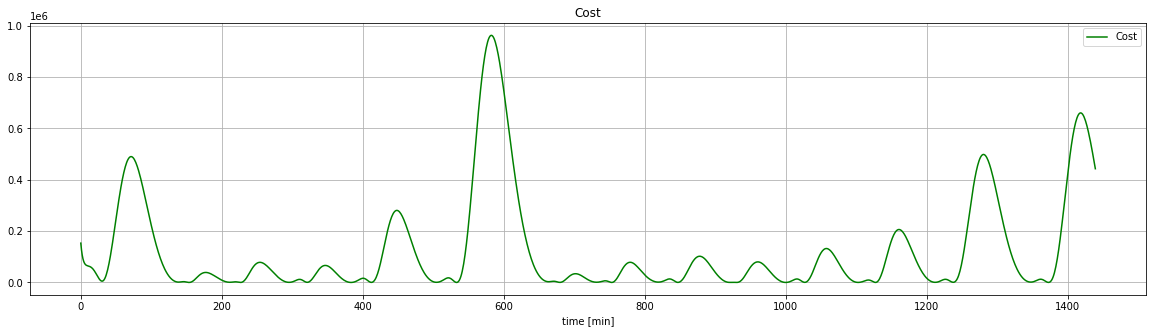

In [5]:
print('------------------------------ PERFORMANCES METRICS ------------------------------')
ISE, ITAE = compute_performance_metrics(data, total_time, t_step, avg_period, LacI_ref, TetR_ref)
print('ISE:', format(ISE, '.2e'))
print('ITAE:', format(ITAE, '.2e'))

print('------------------------------ PLOT RESULTS ------------------------------')
figures, lines = plot_results(data, total_time, avg_period, LacI_ref, TetR_ref)


## Results exportation

In [6]:
export_results(data, 'randomic', 'results', 'w')

## Plots animation

In [7]:
animate_results('randomic', 'proteins', update_protein, figures[0], (data, lines[0:6], np.arange(0, total_time, avg_period)), steps)
animate_results('randomic', 'mRNAs', update_mRNA, figures[1], (data, lines[6:8]), steps)
animate_results('randomic', 'internal_inducers', update_internal_inducers, figures[2], (data, lines[8:10]), steps)
animate_results('randomic', 'external_inducers', update_external_inducers, figures[3], (data, lines[10:12]), steps)
animate_results('randomic', 'cost', update_cost, figures[4], (data, lines[12:13]), steps)